In [1]:
!pip install wfdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 10.7 MB/s eta 0:00:00


# 1. Import Libraries and Set Random Seed
* `wfdb` library is used for working with **physiological signals**, particularly those in PhysioNet format (like the dataset being used). In this case, *we use it to read ECG records and its annotations*.
* **Sets a seed**: For reproducibility, ensuring this way that the same results are obtained on multiple runs

In [2]:
# Import necessary libraries
import wfdb
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from google.colab import drive
import pandas as pd

In [3]:
# Sets a random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# 2. Mount Google Drive, Import local libraries and Load Data
* Mounts the Google Drive to the Colab Environment, allowing access to the MIT-BIH dataset stored there and to the local developed libraries

In [4]:
# Mount drive to access database
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Imports local libraries
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/Masters_Code/Utils')

from ECGUtils import ECGUtils

* **Data Preparation**: We then proceed to obtain the record files from the dataset in the Drive and filter out records with *paced beats*
  * **Paced Beats** are heartbeats that are artificially stimulated by a pacemaker. They have a different morphology (shape) compared to normal heartbeats ('N' beats). These, being artificial, introduce noise and patterns not representative of natural heart function, therefore, they could interfere with the normal hartbeats being used in the study.

In [6]:
# Get the record files from MIT-BIH Database
record_files = glob.glob('/content/drive/My Drive/Colab Notebooks/Datasets/mitbih_data/*.dat')
record_names = [os.path.basename(f).split('.')[0] for f in record_files]

# Remove records with paced beats
excluded_records = ['102', '104', '107', '217']
record_names = [rec for rec in record_names if rec not in excluded_records]

* Iterates through each ECG record, identifies chosen heartbeat type, and extracts segments of the signal around these heartbeats.

In [7]:
segments, labels = ECGUtils.extract_heartbeat_segments(record_names, heartbeat_type='N')

  5%|▍         | 2/44 [00:07<02:37,  3.74s/it]

Stopped Collecting


* In this case, we limit the dataset to 5000 segments to demonstrate the model's capability to work with a smaller dataset. The main goal is to showcase the model's potential for augmenting datasets, with a small input.

In [8]:
# Trim the list to 5000 segments (Only to ensure there are only 5000 segments on the list)
segments = segments[:5000]
print(len(segments))

5000


**Showing an example of a heartbeat segment extracted from the dataset**

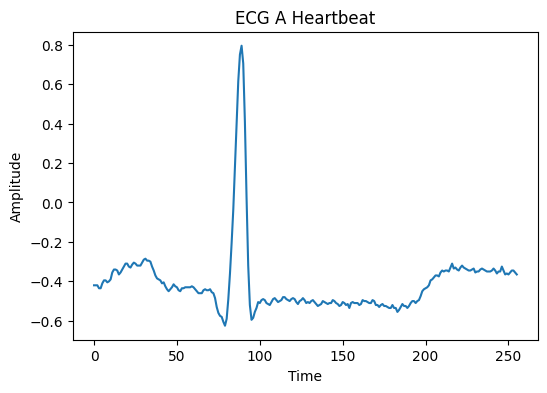

In [9]:
# Plot the sample
plt.figure(figsize=(6, 4))
plt.plot(segments[456])
plt.title(f'ECG A Heartbeat')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

**Showing some more examples of heartbeat segments**

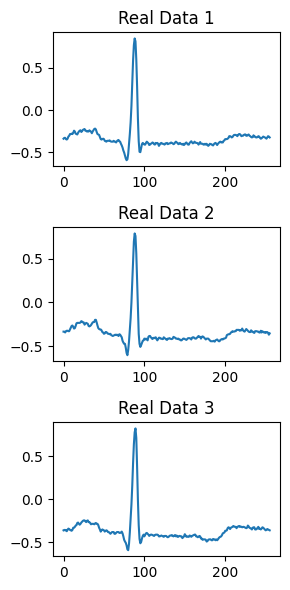

In [10]:
fig, axs = plt.subplots(3, 1, figsize=(3, 6))
for i in range(3):
    axs[i].plot(segments[i+50])
    axs[i].set_title(f'Real Data {i+1}')
plt.tight_layout()
plt.show()

# Data Preprocessing and Visualization

* **Converts the segments list to to a NumPy Array**: This format is more convenient for further processing and analysis.
* **Normalizes the Data**: It is benefitial for the GAN model. It scales the data values *to fall between -1 and 1*. This normalization prepares the data for use in the model, potentially improving the performance and training stability.

In [11]:
# Convert to numpy array
data = np.array(segments)

# Normalize the data to range [-1, 1] if using 'tanh'
data_min = np.min(data)
data_max = np.max(data)
data = 2 * (data - data_min) / (data_max - data_min) - 1

**Showing some examples of normalized heartbeat segments**

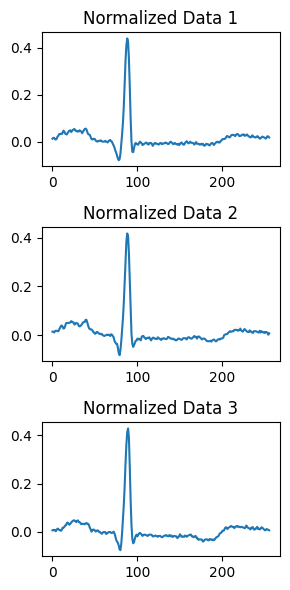

In [12]:
fig, axs = plt.subplots(3, 1, figsize=(3, 6))
for i in range(3):
    axs[i].plot(data[i+50])
    axs[i].set_title(f'Normalized Data {i+1}')
plt.tight_layout()
plt.show()

* Reshaping and changing the data type of the ECG heartbeats to make them suitable for input into the **discriminator model**.
  * The discriminator typically expects a 3D input representing (batch size, sequence length, channels)
    * **Batch size (-1)**: Represents the number of samples processed in one iteration during training. The -1 allows NumPy to infer this dimension **automatically**.
    * **Sequence length (256)**: Corresponds to the length of each ECG heartbeat segment, which is 256 data points.
    * **Channels (1)**: Represents the number of channels in the input data. For ECG data, there is only one channel, as we are using only the "MLII" signal.
  * The data is also converted to `float32` for performance and efficiency, especially when training the model with a GPU (which is this case), given that they often work best with 32-bit floating numbers. Providing a good balance between precision and memory usage.

In [13]:
# Reshape data for the discriminator
data = data.reshape(-1, 256, 1).astype('float32')

# 4. Build and Compile the WGAN-GP Model

## Build the Discriminator
A function called `build_discriminator` is defined, which creates the **discriminator** component of the **GAN**.

* The **Convolutional layers** are used to extract features from the input data (ECG Heartbeat Segments)
  * The first layer specifies an **input shape**, being `256` data points in a single channel (as explained earlier)
  * Each Convolution layer has a certain number of **filters**. Filters are like detectors that learn to identify specific patterns in the input.
  * The **Kernel Size** specifies the size of the convolutional filter. In this case, the kernel sizes are `16`, which means that the filter will consider 16 data points at a time.
    * The `padding='same'` ensures that the output of the convolutional layer has the same dimensions as the input, by adding padding to the edges.
* **LeakyReLU activation functions** are added after every convolutional layer. These functions introduce "non-linearity" into the model, allowing it to learn complex patterns. It helps prevent the **"dying ReLU" problem**, where neurons get stuck and stop learning.
* **Max Pooling layers** are also added, to reduce the spacial dimensions of the data by taking the maximum value within a small window (in this case a window of size `2`). This helps to downsample the data and makes the model more robust to small variations.
* A **Flattening layer** is added to convert the multi-dimensional output of the previous layers into a single, long vector. This is necessary before the dense layer.
* Then, the **dense layer** is added, with a sigle output neuron. This is the final layer, and the output represents the discriminator's prediction of the input being real or fake.

In [14]:
# Build the discriminator
def build_discriminator():
    model = tf.keras.Sequential()

    model.add(layers.Conv1D(32, kernel_size=16, padding='same', input_shape=(256, 1)))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv1D(64, kernel_size=16, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.MaxPooling1D(pool_size=2))

    model.add(layers.Conv1D(128, kernel_size=16, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv1D(256, kernel_size=16, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.MaxPooling1D(pool_size=2))

    model.add(layers.Flatten())

    model.add(layers.Dense(1))
    model.summary()
    return model

## Build the Generator
A function called `build_generator` is defined. It creates a neural network model designed to generate synthetic ECG heartbeat signal segments.

1. **Initialization:**
  * It takes `latent_dim` as input. Representing the size of the random noise vector that will be fed into the generator.
  * Just like in the **discriminator**, a `Sequential` model is created, using Tensorflow Keras.
2. **Input Layer:**
  * The first layer is a `Dense` layer. It takes the random noise vector as input and outputs a vector of size `64 * 128`.
3. **Bidirectional LSTM:**
  * A `Bidirectional LSTM` (Long Short-Term Memory) layer is added. LSTMs are specialized for processing sequential data like ECG signals. The `Bidirectional` function allows the LSTM to process the sequence in both forward and backward directions, capturing temporal dependencies more effectively. The attribute `return_sequences=True` ensures that the output has the same sequence length as the input.
4. **Convolutional and Activation Layers:**
  * Several `Conv1D` (1-dimensional convolutional) layers and `LeakyReLU` activation functions are added.
    * The convolutional layers learn to extract the features from the input sequence.
    * `LeakyReLU` introduces non-linearity, helping the model learrn complex patterns.
    * `padding=same` ensures the output size is the same as the input size.
5. **Upsampling:**
  * `UpSampling1D` layers are used to increase the sequence length. This is done to gradually increase the resolutional of the generated ECG signal.
6. **Output Layer:**
  * The final layer is another convolutional layer with one filter. It produces the output signal.

In [15]:
# Build the generator
def build_generator(latent_dim):
    model = tf.keras.Sequential()

    model.add(layers.Dense(64 * 128, input_dim=latent_dim))
    model.add(layers.Reshape((64, 128)))

    # Bidirectional LSTM layer
    model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True)))

    # Conv1D and LeakyReLU layers
    model.add(layers.Conv1D(128, kernel_size=5, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv1D(64, kernel_size=5, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    # UpSampling to increase the sequence length
    model.add(layers.UpSampling1D(size=2))

    model.add(layers.Conv1D(32, kernel_size=5, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv1D(16, kernel_size=5, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Another UpSampling to reach the desired sequence length
    model.add(layers.UpSampling1D(size=2))

    # Final Conv1D layer to produce the output signal
    model.add(layers.Conv1D(1, kernel_size=5, padding='same', activation='tanh'))
    model.summary()
    return model

## Implementation of WGAN-GP training logic
The purpose of this class is to generate synthetic ECG heartbeat segments by training the generator and discriminator networks **in an adversarial manner**.

1. Firstly, the initiallization class is created. It initializes the WGAN-GP model with the provided generator and discriminator. This class takes several parameters:
  * `discriminator`: The discriminator model that evaluates the authenticity of the data samples.
  * `generator`: The generator model that creates the synthetic ECG Heartbeats from random noise.
  * `latent_dim`: The dimensionality of the input noise vector for the generator.
  * `discriminator_extra_steps`: The number of times the discriminator is trainied per generator training step (the default here is `5`)
    * In this case, the discriminator is updated five times per generator update. This ensures that the discriminator remains sufficiently strong and accurate in estimating the Wasserstein distance between real and generated data distributions.
  * `gp_weight`: The weight for the gradient penalty term in the discriminator loss (the default here is `10`)
    * The gradient penalty is multiplied by this value before being added to the discriminator's loss. This enforces the Lipschitz constraint by penalizing the discriminator when the gradient norm derivates from 1, promoting this way smoother gradients and a more stable training. **Higher values** lead to more stable training but may slow down convergence. **Lower values** speed up training but can lead to unstable training and poorer quality samples generated.
2. The `compile` method compiles the model by setting the optimizers and loss functions for both networks. It stores the optimizers and loss functions as attributes for later use.
  * `d_optimizer`: The optimizer for the discriminator
  * `g_optimizer`: The optimizer for the generator
  * `calc_d_loss`: The loss function for the discriminator
  * `calc_g_loss`: The loss function for the generator
3. The Gradient Penalty method is defined. It calculates the **gradient penalty** for enforcing the Lipschitz constraint. Ensures smoother training and prevents gradient explosion or gradient vanishing. It takes the `batch_size` (number of samples in the current batch), a batch of the real data samples and another of the fake data samples.
  * **Interpolation**
    * Generates random weights (`alpha`) between 0 and 1
    * Interpolates between real and fake samples
  * **Gradient Computation**
    * `tf.GradientTape` is used to watch the interpolated samples. It computes the discriminator's predictions on the interpolated samples. Calculates the gradients of these predictions with respect to the interpolated samples.
  * **Penalty Calculation** computes the L2 norm of the gradients. Calculates the gradient penalty as the mean squared difference between the gradient norms and 1.
4. **Training Step Method** defines a single training step for the model. It trains the discriminator and generator networks according to the WGAN-GP process. It takes a batch of real data samples has a parameter, for training. We use the `@tf.function` decorator to compile the function into a TensorFlow graph for performance optimization.
  * **Discriminator Training**:
    * Trains the discriminator multiple times before updating the generator to improve stability.
    * Samples random noise vectors from a standard normal distribution `random_latent_vectors` and uses the generator to produce synthetic samples.
    * Obtains the predictions by passing real and synthetic samples through the discriminator.
    * Calculates the cost using `calc_d_loss`. Adds the gradient penalty using the `gradient_penalty` method. It combines the calculated cost and the gradient penalty to get the discriminator loss.
    * Finally, it updates the weights by computing the gradients of the loss with respect to the discriminator's parameters. It then aplies the gradients using the optimizer.
  * **Generator Training**:
    * It generates synthetic ECG heartbeats by sampling random noise vectors and using them as input to generate these samples.
    * It passes those generated samples to the discriminator to get the predictions and save the results in `gen_output`
    * Calculates the loss using the `calc_g_loss`.
    * Updates the generator weights by computing the gradients of the loss with respect to the generator's parameters, just like in the discriminator process. It then applies the gradients using the generator optimizer.
  * Lastly it returns a dictionary containing the discriminator and generator losses, to present them during the training.


In [16]:
class WGAN_GP(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim, discriminator_extra_steps=5, gp_weight=10.0):
        super(WGAN_GP, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, calc_d_loss, calc_g_loss):
        super(WGAN_GP, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.calc_d_loss = calc_d_loss
        self.calc_g_loss = calc_g_loss

    def gradient_penalty(self, batch_size, real_samples, fake_samples):
        alpha = tf.random.uniform([batch_size, 1, 1], 0.0, 1.0)
        diff = fake_samples - real_samples
        interpolated = real_samples + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1,2]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    @tf.function
    def train_step(self, real_samples):
        batch_size = tf.shape(real_samples)[0]

        # Train the discriminator
        for _ in range(self.d_steps):
            # Sample random points in the latent space
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

            with tf.GradientTape() as tape:
                # Generate fake samples
                fake_samples = self.generator(random_latent_vectors, training=True)

                # Get discriminator predictions
                real_output = self.discriminator(real_samples, training=True)
                fake_output = self.discriminator(fake_samples, training=True)

                # Calculate discriminator loss
                d_cost = self.calc_d_loss(real_output, fake_output)
                gp = self.gradient_penalty(batch_size, real_samples, fake_samples)
                d_loss = d_cost + gp * self.gp_weight

            # Update the weights of the discriminator
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))

        # Train generator
        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        with tf.GradientTape() as tape:
            # Generate fake samples
            generated_samples = self.generator(random_latent_vectors, training=True)
            # Get discriminator predictions
            gen_output = self.discriminator(generated_samples, training=True)
            # Calculate generator loss
            g_loss = self.calc_g_loss(gen_output)

        # Update the weights of the generator
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))

        return {"d_loss": d_loss, "g_loss": g_loss}

## Loss Functions
The loss functions for both discriminator and generator are defined.

* `discriminator_loss` function computes the Wasserstein Loss for the discriminator. This aims to maximize the difference between the scores for synthetic and real data.
* `generator_loss` computes the loss for the generator. It aims to minimize the discriminator's score for the generated samples. (Trying to make the look as real as possible)

In [17]:
# Define loss functions for both the discriminator and the generator
def discriminator_loss(real_output, fake_output):
    return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)

In [18]:
# Initialize the models
latent_dim = 100
discriminator = build_discriminator()
generator = build_generator(latent_dim)
wgan = WGAN_GP(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 256, 32)             │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 256, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 256, 64)             │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 256, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 128, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 128, 128)            │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 128, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 128, 256)            │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 128, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 64, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          16,385 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 705,505 (2.69 MB)

 Trainable params: 705,505 (2.69 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 8192)                │         827,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 64, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 64, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 64, 128)             │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 64, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 64, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 64, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling1d (UpSampling1D)         │ (None, 128, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 128, 32)             │          10,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 128, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 128, 16)             │           2,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 128, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling1d_1 (UpSampling1D)       │ (None, 256, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 256, 1)              │              81 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,062,209 (4.05 MB)

 Trainable params: 1,062,209 (4.05 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Compile the WGAN-GP process
wgan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5),
    calc_d_loss=discriminator_loss,
    calc_g_loss=generator_loss,
)

# 5. Train the WGAN-GP Model

In [20]:
# Create a dataset
BUFFER_SIZE = data.shape[0]
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices(data)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Epoch 1/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - d_loss: -0.5594 - g_loss: -0.0523

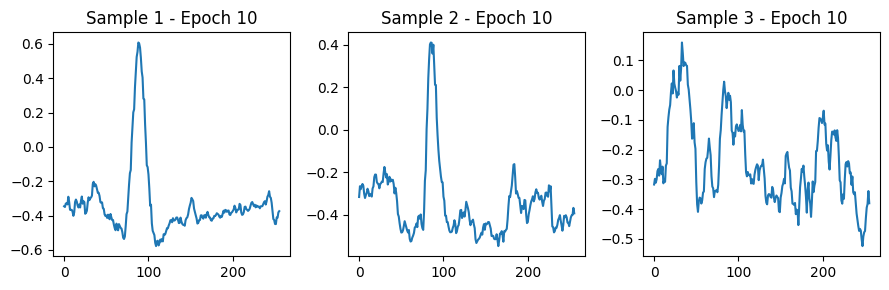

79/79 ━━━━━━━━━━━━━━━━━━━━ 33s 115ms/step - d_loss: -0.5580 - g_loss: -0.0462
Epoch 2/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - d_loss: -0.2999 - g_loss: 0.2433
Epoch 3/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - d_loss: -0.1735 - g_loss: 0.2631
Epoch 4/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - d_loss: -0.1300 - g_loss: 0.9126
Epoch 5/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - d_loss: -0.1263 - g_loss: -1.6662
Epoch 6/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - d_loss: -0.1165 - g_loss: -1.9690
Epoch 7/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - d_loss: -0.1051 - g_loss: -1.8840
Epoch 8/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - d_loss: -0.1097 - g_loss: -2.3691
Epoch 9/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - d_loss: -0.1089 - g_loss: -1.8916
Epoch 10/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - d_loss: -0.1017 - g_loss: -2.2546
Epoch 11/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - d_loss: -0.0970 - g_loss: -1.5815

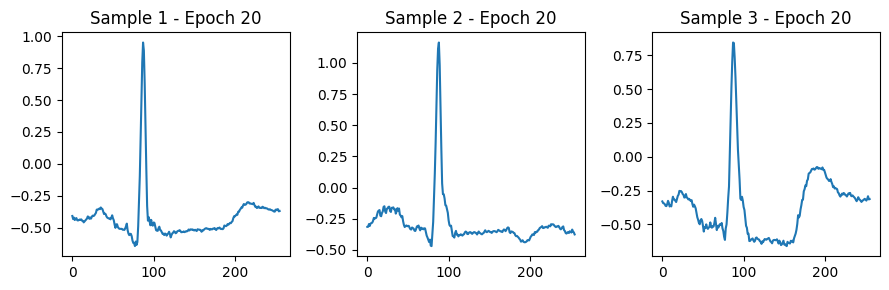

79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - d_loss: -0.0972 - g_loss: -1.5904
Epoch 12/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - d_loss: -0.1021 - g_loss: -1.7521
Epoch 13/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - d_loss: -0.0904 - g_loss: -2.2819
Epoch 14/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - d_loss: -0.0824 - g_loss: -1.0471
Epoch 15/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - d_loss: -0.0810 - g_loss: -2.7540
Epoch 16/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - d_loss: -0.0769 - g_loss: -2.7476
Epoch 17/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - d_loss: -0.0921 - g_loss: -2.3288
Epoch 18/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - d_loss: -0.0639 - g_loss: -2.2220
Epoch 19/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - d_loss: -0.0880 - g_loss: -1.0945
Epoch 20/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - d_loss: -0.0742 - g_loss: -2.2117
Epoch 21/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - d_loss: -0.0742 - g_loss: -1.0505

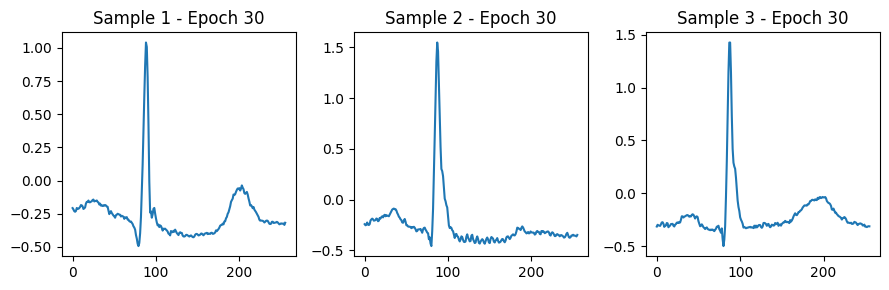

79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - d_loss: -0.0745 - g_loss: -1.0631
Epoch 22/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - d_loss: -0.0852 - g_loss: -2.2065
Epoch 23/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - d_loss: -0.0731 - g_loss: -2.8618
Epoch 24/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - d_loss: -0.0705 - g_loss: -1.8878
Epoch 25/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - d_loss: -0.0646 - g_loss: -1.7715
Epoch 26/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - d_loss: -0.0811 - g_loss: -1.9346
Epoch 27/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - d_loss: -0.0675 - g_loss: -1.8280
Epoch 28/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - d_loss: -0.0787 - g_loss: -2.5061
Epoch 29/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - d_loss: -0.0698 - g_loss: -2.3920
Epoch 30/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - d_loss: -0.0684 - g_loss: -2.0586
Epoch 31/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - d_loss: -0.0758 - g_loss: -1.1243

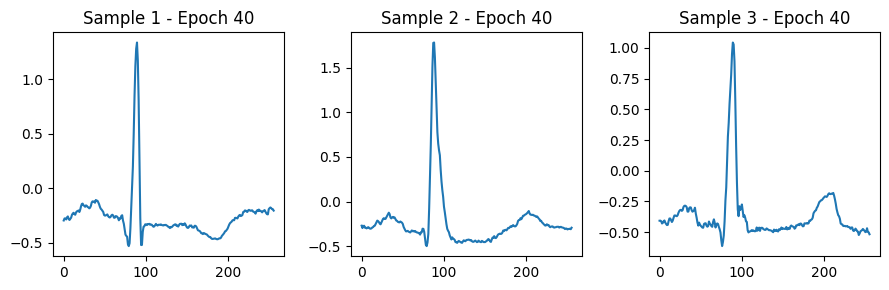

79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - d_loss: -0.0740 - g_loss: -1.1214
Epoch 32/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - d_loss: -0.0725 - g_loss: -1.6232
Epoch 33/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - d_loss: -0.0637 - g_loss: -2.0362
Epoch 34/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - d_loss: -0.0669 - g_loss: -2.5143
Epoch 35/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - d_loss: -0.0687 - g_loss: -1.3123
Epoch 36/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - d_loss: -0.0660 - g_loss: -1.5049
Epoch 37/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - d_loss: -0.0704 - g_loss: -1.7766
Epoch 38/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - d_loss: -0.0706 - g_loss: -1.5882
Epoch 39/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - d_loss: -0.0702 - g_loss: -2.0503
Epoch 40/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - d_loss: -0.0624 - g_loss: -1.2513


In [21]:
# Train the WGAN
EPOCHS = 40

# Use callbacks to generate and save images
class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, num_samples=3, latent_dim=100):
        self.num_samples = num_samples
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
          random_latent_vectors = tf.random.normal(shape=(self.num_samples, self.latent_dim))
          generated_samples = self.model.generator(random_latent_vectors)
          generated_samples = generated_samples.numpy()

          # Denormalize the data
          generated_samples = (generated_samples + 1) / 2  # Scale back to [0, 1]
          generated_samples = generated_samples * (data_max - data_min) + data_min

          fig, axs = plt.subplots(1, self.num_samples, figsize=(9, 3))
          for i in range(self.num_samples):
              axs[i].plot(generated_samples[i].reshape(-1))
              axs[i].set_title(f'Sample {i+1} - Epoch {epoch+10}')
          plt.tight_layout()
          plt.show()

# Start training
wgan.fit(dataset, epochs=EPOCHS, callbacks=[GANMonitor(num_samples=3, latent_dim=latent_dim)])

In [22]:
# Generate new heartbeats
def generate_heartbeat(generator, latent_dim, num_samples=5):
    random_latent_vectors = tf.random.normal(shape=(num_samples, latent_dim))
    generated_samples = generator(random_latent_vectors)
    generated_samples = generated_samples.numpy()
    # Denormalize the data
    generated_samples = (generated_samples + 1) / 2  # Scale back to [0, 1]
    generated_samples = generated_samples * (data_max - data_min) + data_min
    return generated_samples

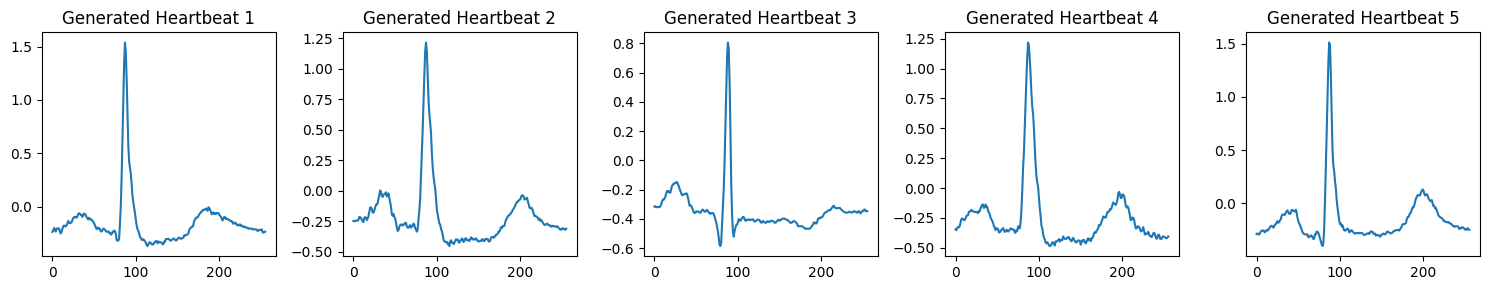

In [23]:
# Generate and plot new heartbeats
generated_heartbeats = generate_heartbeat(generator, latent_dim, num_samples=5)
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axs[i].plot(generated_heartbeats[i].reshape(-1))
    axs[i].set_title(f'Generated Heartbeat {i+1}')
plt.tight_layout()
plt.show()

# 6. Generate and Save New Heartbeats

In [24]:
# Define save paths in Google Drive
generator_save_path = '/content/drive/My Drive/Colab Notebooks/Generated Data/generator_model_N.h5'
generated_data_save_path = '/content/drive/My Drive/Colab Notebooks/Generated Data/generated_heartbeats_N.npy'

In [25]:
# Create directory if it doesn't exist
os.makedirs('/content/drive/My Drive/Colab Notebooks/Generated Data/', exist_ok=True)

In [26]:
# After training, save the generator model
generator.save(generator_save_path)

In [27]:
# Function to generate and save samples
def generate_and_save_samples(generator, latent_dim, num_samples=1000, filename='generated_heartbeats.npy'):
    # Generate random latent vectors
    random_latent_vectors = tf.random.normal(shape=(num_samples, latent_dim))
    # Generate samples using the generator
    generated_samples = generator(random_latent_vectors)
    generated_samples = generated_samples.numpy()
    # Denormalize the data
    generated_samples = (generated_samples + 1) / 2  # Scale back to [0, 1]
    generated_samples = generated_samples * (data_max - data_min) + data_min
    # Save the generated samples to a NumPy file
    np.save(filename, generated_samples)
    print(f"Generated {num_samples} samples and saved to {filename}")

# Generate and save 1000 artificial ECG samples
generate_and_save_samples(generator, latent_dim, num_samples=5000, filename=generated_data_save_path)

Generated 5000 samples and saved to /content/drive/My Drive/Colab Notebooks/Generated Data/generated_heartbeats_N.npy


# 7. Test Generated Data

In [28]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [29]:
print(data.shape)

(5000, 256, 1)


In [30]:
# Combine the data and create labels
# Generate random latent vectors
random_latent_vectors = tf.random.normal(shape=(1000, latent_dim))
# Generate samples using the generator
generated_samples = generator(random_latent_vectors)
generated_samples = generated_samples.numpy()
# Denormalize the data
#generated_samples = (generated_samples + 1) / 2  # Scale back to [0, 1]
#generated_samples = generated_samples * (data_max - data_min) + data_min

In [31]:
print(generated_samples.shape)

(1000, 256, 1)


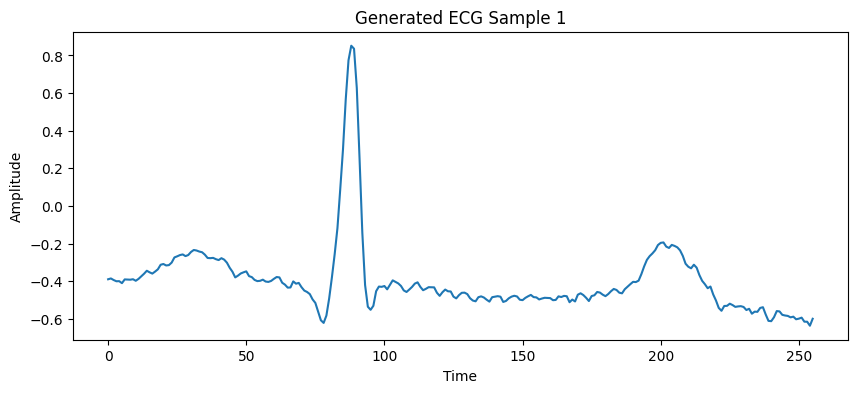

In [32]:
sample_index = 0  # Change this index to visualize other samples

# Extract the sample and reshape to 1 dimensional array
sample = generated_samples[sample_index]  # Shape: (256, 1)
sample = sample.reshape(-1)  # Shape: (256,)

# Denormalize generated data to plot
sample_denormalized = (sample + 1) / 2  # Scale back to [0, 1]
sample_denormalized = sample_denormalized * (data_max - data_min) + data_min

# Plot the sample
plt.figure(figsize=(10, 4))
plt.plot(sample_denormalized)
plt.title(f'Generated ECG Sample {sample_index + 1}')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

## PCA Test
**Principal Component Analysis (PCA)** to evaluate the performance of the model in generating the synthetic signals.

* It compares the orifinal and generated data distributions by plotting them together. This way, it is possible to assess how well the generated samples mimic the distribution of the real data. A close enough overlap indicates that the generator has learned the patterns of the ECG segments effectively.
* Any discrepancies or distinct clusters in the plot can reveal problems like mode collapse or artifacts in the generated data.

In [33]:
generated_data = generated_samples.reshape(generated_samples.shape[0], -1)
original_data_reshaped = data.reshape(data.shape[0], -1)
print(generated_data.shape)
print(original_data_reshaped.shape)

(1000, 256)
(5000, 256)


In [34]:
combined_data = np.vstack((original_data_reshaped, generated_data))

In [35]:
labels = np.array(['Original'] * original_data_reshaped.shape[0] + ['Generated'] * generated_data.shape[0])

In [36]:
scaler = StandardScaler()
combined_data_scaled = scaler.fit_transform(combined_data)

In [37]:
# Fit PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(combined_data)
# Create a DataFrame for plotting
pca_df = pd.DataFrame()
pca_df['PC1'] = pca_result[:, 0]
pca_df['PC2'] = pca_result[:, 1]
pca_df['Label'] = labels

Explained variance by PC1 and PC2: [0.5190634  0.22437206]


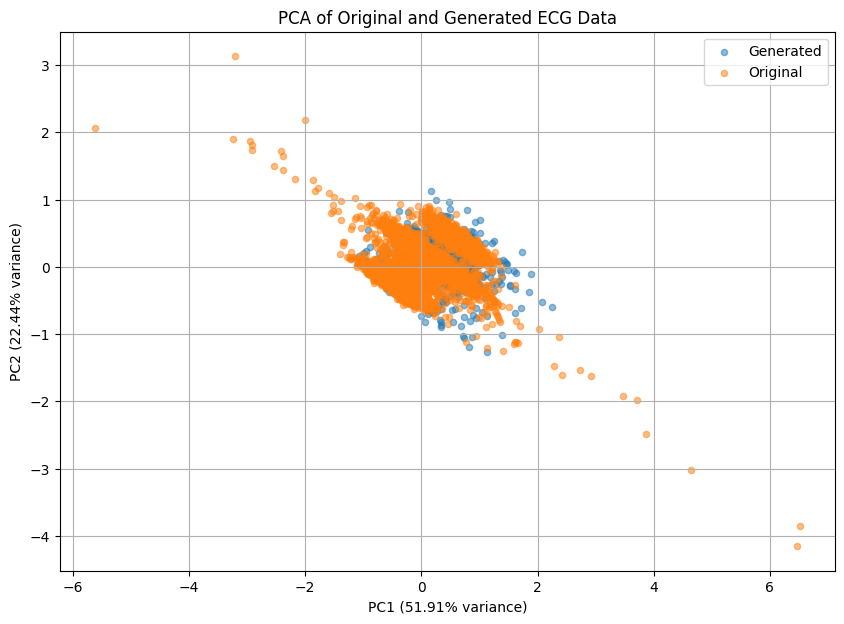

In [38]:
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by PC1 and PC2: {explained_variance}")
plt.figure(figsize=(10, 7))
for label in np.unique(labels):
    indices = pca_df['Label'] == label
    plt.scatter(pca_df.loc[indices, 'PC1'], pca_df.loc[indices, 'PC2'], label=label, alpha=0.5, s=20)

plt.title('PCA of Original and Generated ECG Data')
plt.xlabel(f'PC1 ({explained_variance[0]*100:.2f}% variance)')
plt.ylabel(f'PC2 ({explained_variance[1]*100:.2f}% variance)')
plt.legend()
plt.grid(True)
plt.show()


## t-SNE

**t-distributed Stochastic Neighbor Embedding (t-SNE)** is used to evaluate the effectiveness of the model in generating the signals.

* t-SNE reduces the data to two dimensions while preserving non-linear structures, allowing for a more detailed visualization compraed to linear method like the one above (PCA).
* Just like the PCA, a good overlap suggests that the generator has effectively learned the distribution of the original ECG signals.
* It can reveal whether the synthetic data represents the complex variability present in the original dataset, including some variations that might be missed in linear evaluation methods.

In [39]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_result = tsne.fit_transform(combined_data_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


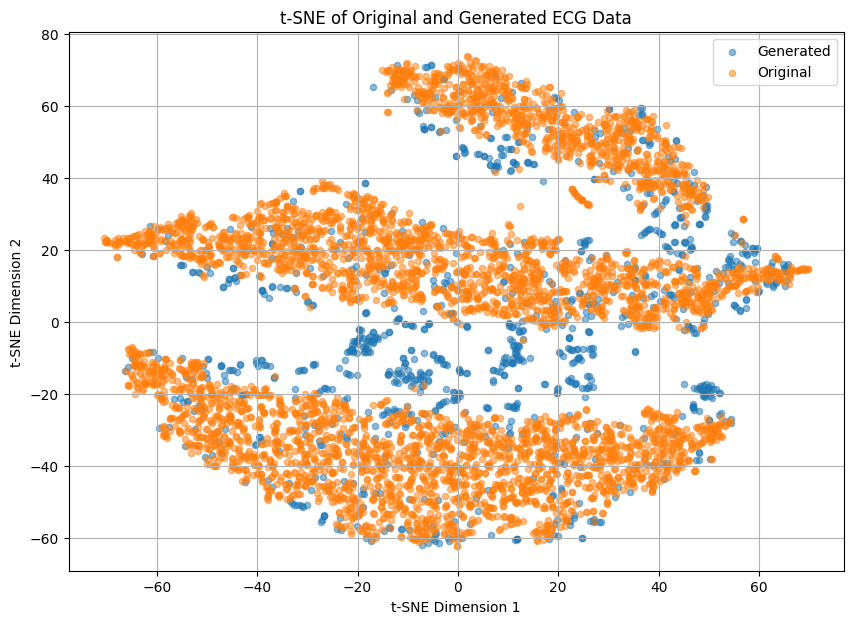

In [40]:
# Create a DataFrame for plotting
tsne_df = pd.DataFrame()
tsne_df['TSNE1'] = tsne_result[:, 0]
tsne_df['TSNE2'] = tsne_result[:, 1]
tsne_df['Label'] = labels

# Plotting
plt.figure(figsize=(10, 7))
for label in np.unique(labels):
    indices = tsne_df['Label'] == label
    plt.scatter(tsne_df.loc[indices, 'TSNE1'], tsne_df.loc[indices, 'TSNE2'], label=label, alpha=0.5, s=20)

plt.title('t-SNE of Original and Generated ECG Data')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

## Compute Statistical Indicators

### Euclidean Distance
* **ED** is used to assess how closely the synthetic data resembles the real data in the feature space.
* A lower ED indicates that the generated heartbeats are more similar to the real heartbeats, suggesting that the genereator has effectively learned the patterns of the signals.
* Higher number may reveal that the generated samples deviate significantly from the original data, indicating issues with the model or training process.

In [41]:
from sklearn.metrics import pairwise_distances

# Compute pairwise distances between generated and original data
distance_matrix = pairwise_distances(generated_data, original_data_reshaped, metric='euclidean')

# For each generated sample, find the minimum distance to original data
min_distances = np.min(distance_matrix, axis=1)

# Compute the average minimum distance
average_ed = np.mean(min_distances)
print(f'Average Euclidean Distance (ED): {average_ed}')

Average Euclidean Distance (ED): 0.30548688769340515


### Dynamic Time Warping (DTW)
* To measure how closely the synthetic heartbeats match the temporal dynamics of the real ones.
* ECG signals often exhibit variations in heartbeat duration and timing due to natural physiological differences, this method accounts for the temporal distortions, providing a more effective measure of similarity.
* A lower DTW indicates that the generated signals closely resemble the real signals in shape and also temporal structure.
* Higher values may reveal that the generated signals deviate significantly in their temporal patterns from the original signals.

In [42]:
# Install fastdtw if not already installed
!pip install fastdtw

from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

# Compute DTW distances
dtw_distances = []

# For computational efficiency, we'll use a subset (e.g., first 100 samples)
num_samples = 1000
for i in range(num_samples):
    gen_sample = generated_data[i]
    # Find the nearest original sample
    nearest_idx = np.argmin(distance_matrix[i])
    orig_sample = original_data_reshaped[nearest_idx]
    # Compute DTW distance
    distance, _ = fastdtw(gen_sample, orig_sample)
    dtw_distances.append(distance)

# Compute the average DTW distance
average_dtw = np.mean(dtw_distances)
print(f'Average Dynamic Time Warping (DTW) Distance (on {num_samples} samples): {average_dtw}')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512543 sha256=690dc84a1890feba231c59acf62286c0a3f3d34201f2a08bd053cd1afe59d049
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4
Successfully built fastdtw
Average Dynamic Time Warping (DTW) Distance (on 1000 samples): 2.061883498082025


### Pearson Correlation Coefficient (PCC)
It quantifies the strength and direction of the linear relationship between two variables. By calculating the PCC between generated and the most similar original ECG signal, we can evaluate how closely the synthetic heartbeats correlate with the real ones in terms of amplitude and shape.

* A PCC value ranges from -1 to 1, where:
  * 1 indicates a perfect positive linear correlation
  * 0 indicates no linear correlation
  * -1 indicates a perfect negative linear correlation

The PCC test provides a a metric to evaluate how well the generator captures the essential characteristics of real ECG signals, including the relationships between different parts of the waveform (P-Wave, QRS Complex, T-Wave).

In [43]:
from scipy.stats import pearsonr

In [44]:
pcc_values = []

for i in range(generated_data.shape[0]):
    gen_sample = generated_data[i]
    # Find the nearest original sample
    nearest_idx = np.argmin(distance_matrix[i])
    orig_sample = original_data_reshaped[nearest_idx]
    # Compute Pearson Correlation Coefficient
    correlation, _ = pearsonr(gen_sample, orig_sample)
    pcc_values.append(correlation)

# Compute the average PCC
average_pcc = np.mean(pcc_values)
print(f'Average Pearson Correlation Coefficient (PCC): {average_pcc}')

Average Pearson Correlation Coefficient (PCC): 0.9743993909533649


### Kullback-Leinler Divergence (KLD)
* It quantifies the difference between two probability distributions. We can asses how closely the generator has replicated the underlying data distribution.
* A lower valye indicates that the generated data closely matches the real data.
* A higher value reveals significant differences between the generated and original data. It could indicate mode collapse or artifacts in the generated data.

In [45]:
from scipy.stats import entropy

# Flatten the data
original_flat = original_data_reshaped.flatten()
generated_flat = generated_data.flatten()

# Compute histograms
bins = 100
orig_hist, bin_edges = np.histogram(original_flat, bins=bins, density=True)
gen_hist, _ = np.histogram(generated_flat, bins=bin_edges, density=True)

# Add a small value to avoid division by zero
epsilon = 1e-10
orig_hist += epsilon
gen_hist += epsilon

# Normalize histograms to sum to 1
orig_hist /= orig_hist.sum()
gen_hist /= gen_hist.sum()

# Compute KLD
kld = entropy(orig_hist, gen_hist)
print(f'Kullback-Leibler Divergence (KLD): {kld}')

Kullback-Leibler Divergence (KLD): 0.06141716950981452
